# Objective: Revenue estimation of Uber cab dataset in a year in NewYork. To aim at looking into insights through Data Analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

%matplotlib inline

In [2]:
df = pd.read_csv(r"D:\JP CERTIFICATES\IITK\Course summerterm\python\Uber_nyc_data.csv\Uber_nyc_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   origin_taz       object 
 2   destination_taz  object 
 3   pickup_datetime  object 
 4   trip_distance    float64
 5   trip_duration    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [4]:
df.shape

(30925738, 6)

In [5]:
# checking for any duplicate values
len(df[df.duplicated() == True])

0

In [6]:
df.isnull().sum()

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

In [7]:
# cheking the origin and drop locations same or any different locations are there
array1 = df.origin_taz.unique()
array2 = df.destination_taz.unique()
set(array2) - set(array1)

{'18', nan}

In [8]:
# we haev 38 Nan values in trip_duration column
# also same 38 Nan values in trip_distance column
df38 = df[df.trip_duration.isnull() & df.trip_distance.isnull()]
df38.shape

(38, 6)

+ here the values of trip duration and distane are missing but the origin and destination are not missing. This implies that the trip had taken place but the values are missing and revenue is being generated from the trip.

### Extracting the pickup_datetime column to datetime type and create related features.

In [9]:
# changing datatype from object to datetime
df['pickup_datetime'].dtype
df['pickup_datetime']

0           2014-09-01 09:00:00
1           2014-09-01 18:00:00
2           2014-09-01 17:00:00
3           2014-09-01 13:00:00
4           2014-09-01 14:00:00
                   ...         
30925733    2015-09-01 00:00:00
30925734    2015-09-01 00:00:00
30925735    2015-09-01 00:00:00
30925736    2015-09-01 00:00:00
30925737    2015-09-01 00:00:00
Name: pickup_datetime, Length: 30925738, dtype: object

+ when we see the data, there is no record where the minutes and seconds are non-zero.

In [10]:
len(df[df.pickup_datetime.apply(lambda x:x[-5:] == '00:00') == False])

0

In [11]:
# we will now create pickup_hour from pickup_datetime column
def dataParser(s):
    return datetime.datetime(int(s[0:4]), int(s[5:7]), int(s[8:10]), int(s[11:13]))

In [12]:
df['pu_date_hour'] = df['pickup_datetime'].apply(dataParser)

In [13]:
df['pu_date_hour'].dtype

dtype('<M8[ns]')

+ we have converted datatype from object to datetime

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   pickup_datetime  object        
 4   trip_distance    float64       
 5   trip_duration    object        
 6   pu_date_hour     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.6+ GB


+ Now we can drop pickup_time column sicne we have pu_hour column

In [15]:
df.drop('pickup_datetime', axis = 1)

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour
0,252581,7C,6A,4.25,0:15:11,2014-09-01 09:00:00
1,252582,7B,15,10.17,0:34:05,2014-09-01 18:00:00
2,252583,11,2A,4.02,0:17:06,2014-09-01 17:00:00
3,252584,3B,4A,1.46,0:06:32,2014-09-01 13:00:00
4,252585,2A,10,8.31,0:26:17,2014-09-01 14:00:00
...,...,...,...,...,...,...
30925733,30693431,15,15,6.86,0:27:37,2015-09-01 00:00:00
30925734,30693447,5B,2A,3.44,0:11:07,2015-09-01 00:00:00
30925735,30693461,4C,NaN,6.17,0:19:10,2015-09-01 00:00:00
30925736,30693466,2A,5A,1.87,0:07:54,2015-09-01 00:00:00


In [16]:
# checking the time range of the data
begining_date = df['pu_date_hour'].min()
end_date = df['pu_date_hour'].max()

In [17]:
begining_date

Timestamp('2014-09-01 00:00:00')

In [18]:
end_date

Timestamp('2015-09-01 00:00:00')

In [19]:
end_date - begining_date

Timedelta('365 days 00:00:00')

## Get the federal holidays for the period (useful for analyzing date later)

In [20]:
# get all federal holidays in the period
from pandas.tseries.holiday import USFederalHolidayCalendar

# Create an instance of the USFederalHolidayCalendar
holidays = USFederalHolidayCalendar().holidays(start = begining_date, end = end_date, return_name = True)
holidays

2014-09-01                              Labor Day
2014-10-13                           Columbus Day
2014-11-11                           Veterans Day
2014-11-27                       Thanksgiving Day
2014-12-25                          Christmas Day
2015-01-01                         New Year's Day
2015-01-19    Birthday of Martin Luther King, Jr.
2015-02-16                  Washington's Birthday
2015-05-25                           Memorial Day
2015-07-03                       Independence Day
dtype: object

+ Now we will see the day before and after each public holiday and analyse the number of Uber rides

In [21]:
# extrat day of the holiday
holidays.index.map(lambda x: x.strftime('%a'))

Index(['Mon', 'Mon', 'Tue', 'Thu', 'Thu', 'Thu', 'Mon', 'Mon', 'Mon', 'Fri'], dtype='object')

In [22]:
# Generate day before and after the holidays
holidays_bef_aft = pd.concat([holidays, 'Day After ' + holidays.shift(1, 'D'), 'Day Before ' + holidays.shift(-1, 'D')])
holidays_all = holidays_bef_aft.sort_index()
holidays_all

2014-08-31                              Day Before Labor Day
2014-09-01                                         Labor Day
2014-09-02                               Day After Labor Day
2014-10-12                           Day Before Columbus Day
2014-10-13                                      Columbus Day
2014-10-14                            Day After Columbus Day
2014-11-10                           Day Before Veterans Day
2014-11-11                                      Veterans Day
2014-11-12                            Day After Veterans Day
2014-11-26                       Day Before Thanksgiving Day
2014-11-27                                  Thanksgiving Day
2014-11-28                        Day After Thanksgiving Day
2014-12-24                          Day Before Christmas Day
2014-12-25                                     Christmas Day
2014-12-26                           Day After Christmas Day
2014-12-31                         Day Before New Year's Day
2015-01-01              

## Creating other data and time features

In [23]:
# parsing date from pu_date_hour
df['pu_date'] = pd.Series(map(lambda x:x.astype('datetime64[D]'), df['pu_date_hour'].values))

In [24]:
df.head(10)

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour,pu_date
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01
5,252586,5B,4C,2014-09-01 12:00:00,1.04,0:08:35,2014-09-01 12:00:00,2014-09-01
6,252587,10,10,2014-09-01 14:00:00,1.44,0:19:36,2014-09-01 14:00:00,2014-09-01
7,252588,2A,7A,2014-09-01 03:00:00,5.08,0:18:17,2014-09-01 03:00:00,2014-09-01
8,252589,2B,3C,2014-09-01 11:00:00,1.64,0:07:29,2014-09-01 11:00:00,2014-09-01
9,252590,9,5B,2014-09-01 20:00:00,16.63,0:28:37,2014-09-01 20:00:00,2014-09-01


In [25]:
# Getting month and year and day from pcikup timestamp
df['year'] = df['pu_date_hour'].dt.year
df['month'] = df['pu_date_hour'].dt.month
df['day'] = df['pu_date_hour'].dt.day
df['hour'] = df['pu_date_hour'].dt.hour
df['weekday'] = df['pu_date_hour'].dt.dayofweek

df.head(10)

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0
5,252586,5B,4C,2014-09-01 12:00:00,1.04,0:08:35,2014-09-01 12:00:00,2014-09-01,2014,9,1,12,0
6,252587,10,10,2014-09-01 14:00:00,1.44,0:19:36,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0
7,252588,2A,7A,2014-09-01 03:00:00,5.08,0:18:17,2014-09-01 03:00:00,2014-09-01,2014,9,1,3,0
8,252589,2B,3C,2014-09-01 11:00:00,1.64,0:07:29,2014-09-01 11:00:00,2014-09-01,2014,9,1,11,0
9,252590,9,5B,2014-09-01 20:00:00,16.63,0:28:37,2014-09-01 20:00:00,2014-09-01,2014,9,1,20,0


In [26]:
df['weekday'].value_counts()

weekday
5    5142832
4    4805002
3    4625511
6    4331195
2    4301537
1    4010434
0    3709227
Name: count, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   origin_taz       object        
 2   destination_taz  object        
 3   pickup_datetime  object        
 4   trip_distance    float64       
 5   trip_duration    object        
 6   pu_date_hour     datetime64[ns]
 7   pu_date          datetime64[ns]
 8   year             int32         
 9   month            int32         
 10  day              int32         
 11  hour             int32         
 12  weekday          int32         
dtypes: datetime64[ns](2), float64(1), int32(5), int64(1), object(4)
memory usage: 2.4+ GB


+ Year, month, day and hour, weekday featuers were created for better analysis

## Transform/Parse trip_duration data

In [28]:
unique_durations = df[df['trip_duration'].isnull() == False].trip_duration.unique()

In [29]:
len(unique_durations)

19393

In [30]:
# fingind the durations with >=10hours
long_duration = []
for i in unique_durations:
    if len(i)!=7 :
        long_duration.append(i)
# length of such durations
len(long_duration)

386

In [31]:
# Unsusual strings where trip duration is more than expected
for i in long_duration:
    if len(i) > 8:
        print(i)

172032:14:50
172032:39:03
136:25:12
172032:17:45
172032:19:27
119:53:35
120:49:05


In [32]:
# Calling a function
def duration_to_minutes(s):
    '''takes a string of hh:mm:ss format and 
    returns integer values pf total time in minutes, or
    zero for missing values in pandas df'''
    if pd.isnull(s):
        val = 0
    else:
        hms = s.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val


In [33]:
# converting string value to minutes
df['duration_in_min'] = df['trip_duration'].apply(duration_to_minutes)
df.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_in_min
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.183333
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.083333
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.100000
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.533333
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.283333


+ So, in this section we converted all the hourlu duratond aat to minutes for better analysis in later part.

## Filling the null data of distance and duration with mean data for respective origin_destination

In [34]:
# groupby origin_taz and destination_taz and find mean of trip_distance and duration_in_min 
Distance_duration = df.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'duration_in_min']].mean()

In [35]:
Distance_duration.head()

trip_distance  duration_in_min
origin_taz destination_taz                                
1          1                     1.421855        10.565513
           10                    3.650791        17.977578
           11                    5.093679        22.489925
           12                    8.887789        29.102406
           13                   11.583137        32.156759

In [36]:
# since we have 38 nan values in trip_distane and trip_duration, replace with mean for respective origin_destination pair
# consider df38 dataFrame
for i in df38.index:
    origin = df.loc[i, 'origin_taz']
    destination = df.loc[i, 'destination_taz']
    df.loc[i, 'trip_distance'] = Distance_duration.loc[origin, destination].trip_distance
    df.loc[i, 'duration_in_min'] = Distance_duration.loc[origin, destination].duration_in_min

In [37]:
df

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_in_min
0,252581,7C,6A,2014-09-01 09:00:00,4.25,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.183333
1,252582,7B,15,2014-09-01 18:00:00,10.17,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.083333
2,252583,11,2A,2014-09-01 17:00:00,4.02,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.100000
3,252584,3B,4A,2014-09-01 13:00:00,1.46,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.533333
4,252585,2A,10,2014-09-01 14:00:00,8.31,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.283333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30925733,30693431,15,15,2015-09-01 00:00:00,6.86,0:27:37,2015-09-01 00:00:00,2015-09-01,2015,9,1,0,1,27.616667
30925734,30693447,5B,2A,2015-09-01 00:00:00,3.44,0:11:07,2015-09-01 00:00:00,2015-09-01,2015,9,1,0,1,11.116667
30925735,30693461,4C,NaN,2015-09-01 00:00:00,6.17,0:19:10,2015-09-01 00:00:00,2015-09-01,2015,9,1,0,1,19.166667
30925736,30693466,2A,5A,2015-09-01 00:00:00,1.87,0:07:54,2015-09-01 00:00:00,2015-09-01,2015,9,1,0,1,7.900000


In [38]:
df.isnull().sum()

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance            0
trip_duration           38
pu_date_hour             0
pu_date                  0
year                     0
month                    0
day                      0
hour                     0
weekday                  0
duration_in_min          0
dtype: int64

## Calculate average speed for each trip

In [39]:
# Calculating avg speed in mph to understand outliers (tripshaving >10h duration)
df['trip_avg_speed'] = df['trip_distance']/(df['duration_in_min']/60)

In [40]:
# Checking that Nan values are filled and avg speed column updated.
df.iloc[df38.index, :].head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed
15155317,39535,2A,11,2015-04-25 12:00:00,3.936804,NaN,2015-04-25 12:00:00,2015-04-25,2015,4,25,12,5,19.732101,11.970759
15245057,1009076,2A,2A,2015-04-26 01:00:00,1.358751,NaN,2015-04-26 01:00:00,2015-04-26,2015,4,26,1,6,10.919522,7.465989
16519652,15028665,2A,7C,2015-04-29 21:00:00,9.039374,NaN,2015-04-29 21:00:00,2015-04-29,2015,4,29,21,2,30.204064,17.956604
17148253,22250173,2A,2A,2015-04-12 02:00:00,1.358751,NaN,2015-04-12 02:00:00,2015-04-12,2015,4,12,2,6,10.919522,7.465989
17297563,23716998,2C,11,2015-04-25 13:00:00,4.833061,NaN,2015-04-25 13:00:00,2015-04-25,2015,4,25,13,5,24.385143,11.891817


In [41]:
# since we parsed the duration and date hour columns, so we will remove the duplciate columns
df = df.drop('trip_duration', axis = 1)
df = df.drop('pu_date_hour', axis = 1)

## Calculating estimated revenue per trip

In [42]:
# from a Newyork source for Uber X
base_fare = 2.55
per_minute = 0.35
per_mile = 1.75
min_fare = 8

In [43]:
#
df['est_revenue'] = df.eval('@base_fare + duration_in_min * @per_minute + trip_distance * @per_mile')
df.loc[df['est_revenue'] < 8, 'est_revenue'] = min_fare

In [44]:
df.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed,est_revenue
0,252581,7C,6A,2014-09-01 09:00:00,4.25,2014-09-01,2014,9,1,9,0,15.183333,16.794731,15.301667
1,252582,7B,15,2014-09-01 18:00:00,10.17,2014-09-01,2014,9,1,18,0,34.083333,17.903178,32.276667
2,252583,11,2A,2014-09-01 17:00:00,4.02,2014-09-01,2014,9,1,17,0,17.100000,14.105263,15.570000
3,252584,3B,4A,2014-09-01 13:00:00,1.46,2014-09-01,2014,9,1,13,0,6.533333,13.408163,8.000000
4,252585,2A,10,2014-09-01 14:00:00,8.31,2014-09-01,2014,9,1,14,0,26.283333,18.970197,26.291667


# Checking for Data Consistency

## Anamalous cases of trip duration

In [45]:
# checking for long durations which effect the revenue numbers
# >100 hours
a = df[df['duration_in_min']>=6000]

# >16hours and <100h : 116 entries
b = df[(df['duration_in_min']>960) & (df['duration_in_min']<6000)].est_revenue.sum()

In [46]:
print(len(a))
print(b)

7
78069.74916666666


+ here, there are 7 entries where the duration is >100hours. There can be fraud or error. These 7 entries constitute big revenue.
+ We will drop these 7 rows which are outliers.

In [47]:
# checking whether the trip_distance and trip_duration equal to zero actually cancelled?
print(len(df[(df.duration_in_min == 0) & (df.trip_distance == 0)]))

# checking intersection of duration 0, distance 0 and origin!= destination.
print(len(df[(df['duration_in_min'] ==0) & (df['trip_distance'] ==0) & (df['origin_taz'] != df['destination_taz'])]))

# checking cases where distacne is 0 but duration is >0
print(len(df[(df['duration_in_min'] > 0) & (df['trip_distance'] ==0)]))

# checking duration >5, distance = 0, origin!=destination
print(len((df['duration_in_min']>5) & (df['trip_distance']==0) & (df['origin_taz'] != df['destination_taz'])))

# checking the trips with average speed lower than waling speed i.e 3mph
print(len(df[df['trip_avg_speed']<=3]))

# cheking <3 and <2 mph
print(len(df[(df['trip_avg_speed'] <=3) & (df['trip_distance'] <= 2)]))

# checking intersection of speed<3, 90<duration<960
df[(df['trip_avg_speed']<=3) & (df['duration_in_min'] >90) & (df['duration_in_min']<=960)].head(10)

24866
910
85515
30925738
262666
246225


,id,origin_taz,destination_taz,pickup_datetime,trip_distance,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed,est_revenue
539,253120,5B,10,2014-09-02 11:00:00,8.34,2014-09-02,2014,9,2,11,1,173.366667,2.886368,77.823333
7798,260379,6A,6A,2014-09-11 12:00:00,6.01,2014-09-11,2014,9,11,12,3,128.150000,2.813890,57.920000
14734,267315,6B,5C,2014-09-19 13:00:00,9.08,2014-09-19,2014,9,19,13,4,196.250000,2.776051,87.127500
14996,267577,4C,6A,2014-09-20 15:00:00,5.48,2014-09-20,2014,9,20,15,5,110.700000,2.970190,50.885000
17131,269712,2A,NaN,2014-09-21 20:00:00,4.88,2014-09-21,2014,9,21,20,6,100.466667,2.914399,46.253333
21955,274536,6B,6B,2014-09-29 12:00:00,2.97,2014-09-29,2014,9,29,12,0,91.083333,1.956450,39.626667
22567,275148,4C,4C,2014-09-30 14:00:00,1.37,2014-09-30,2014,9,30,14,1,106.483333,0.771952,42.216667
24080,736706,6B,3A,2014-09-02 16:00:00,6.05,2014-09-02,2014,9,2,16,1,243.216667,1.492496,98.263333
27977,740603,4C,2B,2014-09-07 18:00:00,4.99,2014-09-07,2014,9,7,18,6,129.950000,2.303963,56.765000
29077,741703,4A,5A,2014-09-08 15:00:00,7.94,2014-09-08,2014,9,8,15,0,208.450000,2.285440,89.402500


+ considering the less speed of vehicles, it resembles very bad traffic, iterrupted trips or fraud
+ In this list, we have anamolous cases where they show very long duration.

In [48]:
len(df[(df['month'] == 8) & (df['year'] == 2015)])

3368433

+ 2.4% of estimated revenue by considering trip duration >100 hour and >16hour would be system error and sholud ot be considered for estimateing revenue.
+ 24866 cases are cancelled trips and are vomited in revenue estimation
+ avg speed < 3km are also vomited from revenue estimation.
                                                                                                                    

## Filtering the Dataset

In [49]:
# some data is beyond the timezone. we will check them if any.
len(df[df['pu_date'] == datetime.date(2015, 9, 1)])

0

In [50]:
df.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed,est_revenue
0,252581,7C,6A,2014-09-01 09:00:00,4.25,2014-09-01,2014,9,1,9,0,15.183333,16.794731,15.301667
1,252582,7B,15,2014-09-01 18:00:00,10.17,2014-09-01,2014,9,1,18,0,34.083333,17.903178,32.276667
2,252583,11,2A,2014-09-01 17:00:00,4.02,2014-09-01,2014,9,1,17,0,17.100000,14.105263,15.570000
3,252584,3B,4A,2014-09-01 13:00:00,1.46,2014-09-01,2014,9,1,13,0,6.533333,13.408163,8.000000
4,252585,2A,10,2014-09-01 14:00:00,8.31,2014-09-01,2014,9,1,14,0,26.283333,18.970197,26.291667


In [51]:
# Creating dataframe with only 1 year timeline

In [55]:
df_copy = df[(df['pu_date'] != datetime.date(2015, 9, 1)) & (df['duration_in_min'] <= 960)].copy()

In [56]:
len(df_copy)

30925615

In [57]:
# Descriptive analysis for numerical features
df_copy[['duration_in_min', 'trip_distance', 'trip_avg_speed', 'est_revenue']].describe()

,duration_in_min,trip_distance,trip_avg_speed,est_revenue
count,3.092562e+07,3.092562e+07,3.090075e+07,3.092562e+07
mean,2.099209e+01,5.199671e+00,1.350735e+01,1.924186e+01
std,1.608435e+01,6.130770e+00,1.175680e+01,1.508085e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
25%,1.085000e+01,1.690000e+00,8.410012e+00,9.573333e+00
50%,1.723333e+01,3.090000e+00,1.144891e+01,1.435083e+01
75%,2.668333e+01,6.230000e+00,1.626687e+01,2.303083e+01
max,9.593000e+02,5.685700e+02,2.254800e+04,1.225858e+03


In [58]:
import matplotlib.mlab as mlab

In [59]:
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Ellipse

In [60]:
# creating functions
def thousands_comma(x, pos):
    '''
    x, pox are value and tick position
    returns number with thousands comma and no decimals.'''
    return '{:,.0f}'.format(x)

In [101]:
def thousands_format(x, pos):
    """
    Args are the value and tick position. 
    Returns number of thousands with one decimal, and K in lieu of 3 zeros.
    """
    return '{:.0f}{}'.format(x * 1e-3, 'K') #old syntax: '%1.0fK' % (x * 1e-3)

In [61]:
def millions_currency(x, pos):
    '''
    Returns number of millions with a sign $,, and lieu to 6 zeros with M and no decimals
    '''
    return '{:.0f}{}'.format('$', x * 1e-6, 'M')

In [62]:
def millions_format(x, pos):
    '''
    Returns number of millions with one decimal, and m in lieu of 6 zeros.
    '''
    return '{:.1f}{}'.format(x *1e-6, 'M')

In [63]:
#Define robust function to automatically add annotated labels on bar plots.
#Inspiration from http://composition.al/blog/2015/11/29/a-better-way-to-add-labels-to-bar-charts-with-matplotlib/

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
        return None

+ Written fucntions are used to represent large numbers in thousands(K) and millions(M) format 

## Visualizing the demand: number of Uber trips per day.

In [64]:
# Creating a plot for count of number of trips grouped by day:
byDate = df_copy.groupby('pu_date')['id'].count()
byDate.head()

pu_date
2014-09-01    31592
2014-09-02    41496
2014-09-03    46339
2014-09-04    53402
2014-09-05    59718
Name: id, dtype: int64

In [65]:
# uptick in rides on 11/01, the day before the NYC marathon
byDate['2014-10-28' : '2014-11-05']

pu_date
2014-10-28     52084
2014-10-29     61082
2014-10-30     66369
2014-10-31     71787
2014-11-01    104450
2014-11-02     57289
2014-11-03     50491
2014-11-04     52395
2014-11-05     61518
Name: id, dtype: int64

In [66]:
byDate['2015-06-01': '2015-08-31'].mean()

107630.82608695653

NameError: name 'thousands_format' is not defined

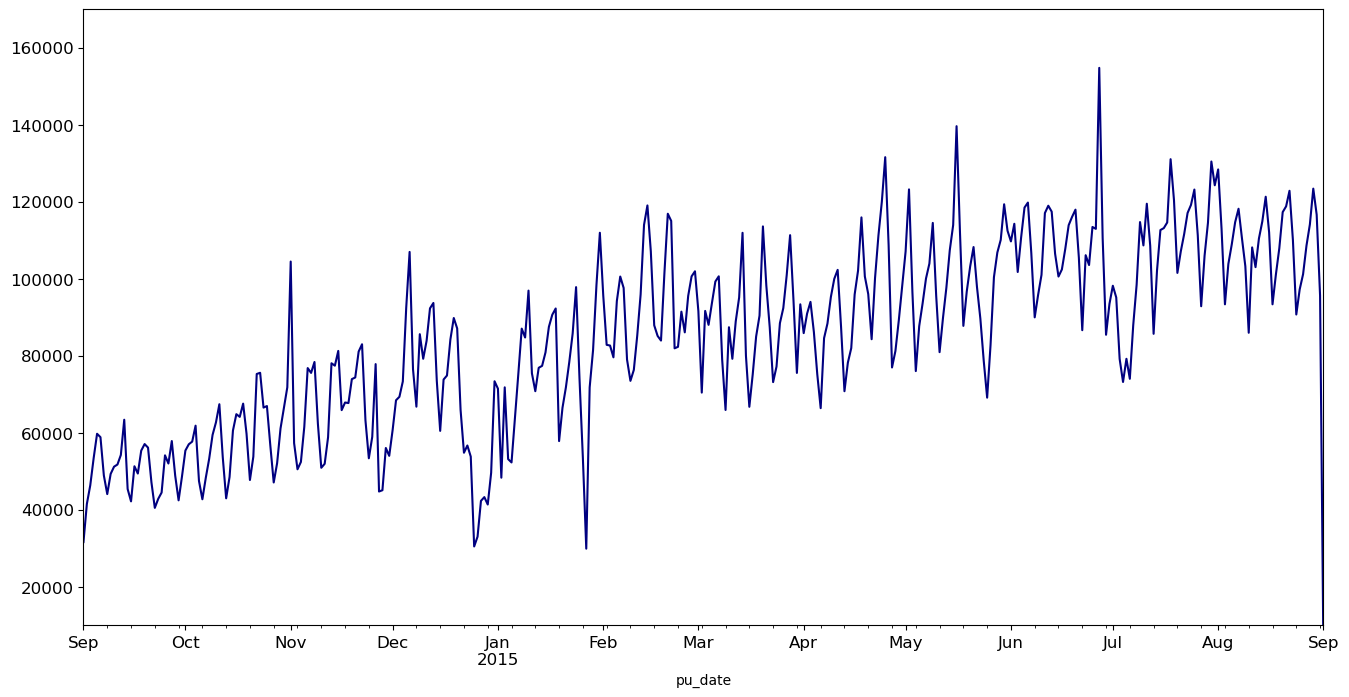

In [67]:
#Create a plot with the total number of trips per day, highlighting some changepoints associated with major holidays 
#and other weather and touristic/cultural events.
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import FuncFormatter
from matplotlib.image import imread

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

formatter = FuncFormatter(thousands_format)
ax.yaxis.set_major_formatter(formatter)
ax.set_facecolor('#F9F9F9') #make background color a lighter gray to better contrast with the icon's images.

plt.title('Total Trips per Day with Annotation of Some Major Events and Holidays', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')


#Add icon to indicate snowstorm on the plot:
#NYC's mayor ordered the city under curfew, and public transportation system was shut down late on 1/26/15.
img1 = imread('Snow.png')
imagebox = OffsetImage(img1, zoom=0.6)
xy = ['2015-01-27', 25000] # (len(byDate[:'2015-01-27'])-1, byDate['2015-01-27'])

ab = AnnotationBbox(imagebox, xy, 
                    xybox=(22., 10.), #position from xy to lower left corner of box
                    xycoords='data', #will use data coordinates for x and y
                    boxcoords='offset points', #same idea as textcoords, in points from lower left corner
                    pad=0.1, frameon=False) #padding around the image
ax.add_artist(ab)


#Add icon to indicate Thanksgiving on the plot:
img2 = imread('thanksgiving.jpg')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-11-27', 40000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)
#Add icon to indicate Christmas on the plot:
img2 = imread('ctree.jpg')
imagebox = OffsetImage(img2, zoom=0.6) 
xy = ['2014-12-25', 25000] 
ab = AnnotationBbox(imagebox, xy, xybox=(10., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Memorial Day Holiday on the plot:
img3 = imread('mday.jpg')
imagebox = OffsetImage(img3, zoom=0.6) 
xy = ['2015-05-25', 60000] 
ab = AnnotationBbox(imagebox, xy, xybox=(1., 5.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Pride Week on the plot:
#According to The Wall Street Journal, the Pride Parade was attended by 1.6 million people in 2015.
img4 = imread('rainbow.png')
imagebox = OffsetImage(img4, zoom=0.6) 
xy = ['2015-06-27', 150000] 
ab = AnnotationBbox(imagebox, xy, xybox=(18., 2.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate Independence Day Holiday on the plot:
img5 = imread('iday.jpg')
imagebox = OffsetImage(img5, zoom=0.6) 
xy = ['2015-07-03', 70000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., -10.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

#Add icon to indicate NYC Marathon event on the plot:
img5 = imread('marathon.jpg')
imagebox = OffsetImage(img5, zoom=0.7) 
xy = ['2014-11-01', 110000] 
ab = AnnotationBbox(imagebox, xy, xybox=(5., 7.), xycoords='data', boxcoords='offset points', pad=0.1, frameon=False)
ax.add_artist(ab)

plt.show()

* **The effect of major events on the number of trips**. 

 * negative impacts are related to Thanksgiving, Christmas, Memorial Day, and Independence Day. 
 * A lingering (two consecutive days) drop in activity is seen for all these holidays but Memorial Day. It turns out that the July 4th holiday was observed on Friday in 2015.

  * an apparently odd and very significant drop in the number of trips is shown on January 27th. This was a result of a curfew imposed by the NYC’s mayor in preparation for a blizzard.

 * The plot also highlights which events have positively impacted the number of trips that year, with the International Marathon and the Gay Pride Week standing out as the strongest contributors. ibutors.

# The effect of time on demand for Uber rides: distribution per hour, weekday, and month.

In [68]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

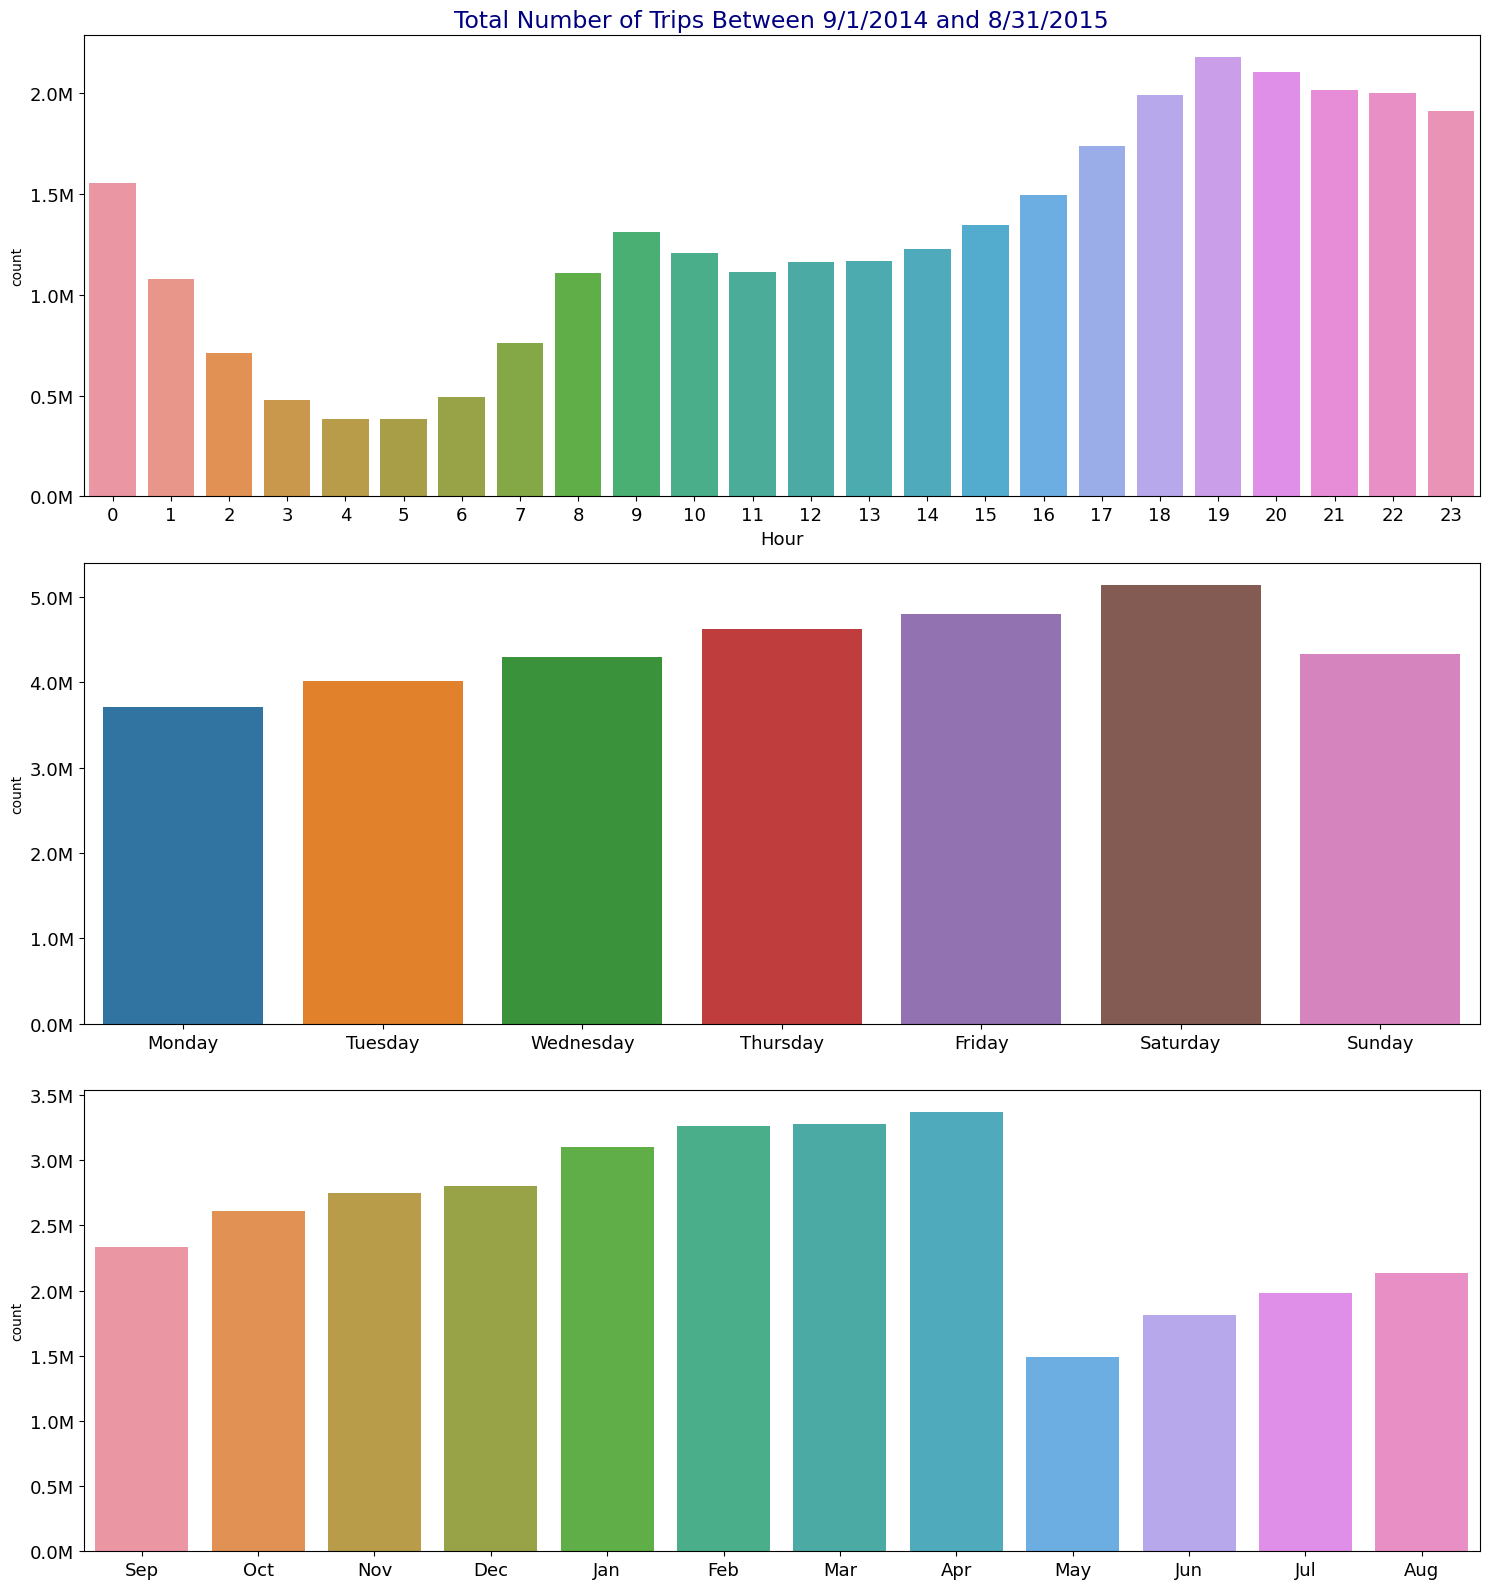

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Assuming you have defined millions_format function

# Example data or your data loading logic
# df_viz = ...

fig = plt.figure(figsize=(15, 16))
formatter = FuncFormatter(millions_format)

plt.subplot(3, 1, 1)
ax1 = sns.countplot(data=df_copy, x='hour', order=range(24))
ax1.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips Between 9/1/2014 and 8/31/2015', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3, 1, 2)
ax2 = sns.countplot(data=df_copy, x='weekday', order=range(7))
ax2.set_xticklabels(weekday_labels)
ax2.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3, 1, 3)
ax3 = sns.countplot(data=df_copy, x='month')
ax3.set_xticklabels(month_labels)
ax3.yaxis.set_major_formatter(formatter)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

* The **demand for Uber is higher** from 4 PM until about midnight, as shown in the bar charts above.
* The second chart shows a progressive increase in demand from Monday through Saturday, with Saturday having the highest demand. Fascinatingly, demand on Sunday is larger than on Monday or Tuesday and is comparable to that on Wednesday.
* The steady month-to-month growth obscures seasonal impacts when examining the total demand for each month across the study period.

# Estimated Monthly Base Revenue: how much was the NYC market worth in the period?

* Thanks to the dataset's availability of each trip's duration and distance, Uber's revenue in New York City can now be estimated with greater precision than before. The revenue data are referred to as "base revenue" due to the absence of other crucial information.

* Uber provides several service categories (Uber X, Uber XL, Uber Black, Uber SUV, and Uber Pool) at various price points. Every other service, with the exception of Uber X, charges a greater fee. Additionally, Uber engages in "price surging," which boosts income.

* Since Uber X is arguably the most well-liked product, we decided to utilize its published fares in this case to determine income. As a result, the base revenue is a cautious approximation of the reveue.


In [77]:
# create dataframe with grouped revenue data:
byDateRev = df_copy.groupby('month')['est_revenue'].sum()

In [78]:
# estimating the Ubers total margin for the entire 1 year based on base revenues 25% share.
sumRev = byDateRev.sum()
print("Base Revenue: ${:,.0f}M".format(sumRev * 1e-6), "Uber's Base Gross Margin: ${:,.0f}".format(sumRev * .25))

Base Revenue: $595M Uber's Base Gross Margin: $148,766,619


In [80]:
#Estimated base gross margin based on information that average UberX fare in Sep 2014 was $27 (but it has dropped):
len(df_copy) * 27 * .25

208747901.25

In [81]:
byDateRev.head()

month
1    4.145715e+07
2    4.725285e+07
3    5.215439e+07
4    5.409507e+07
5    6.153991e+07
Name: est_revenue, dtype: float64

In [82]:
sumRev= byDateRev.sum()
sumRev

595066477.5641053

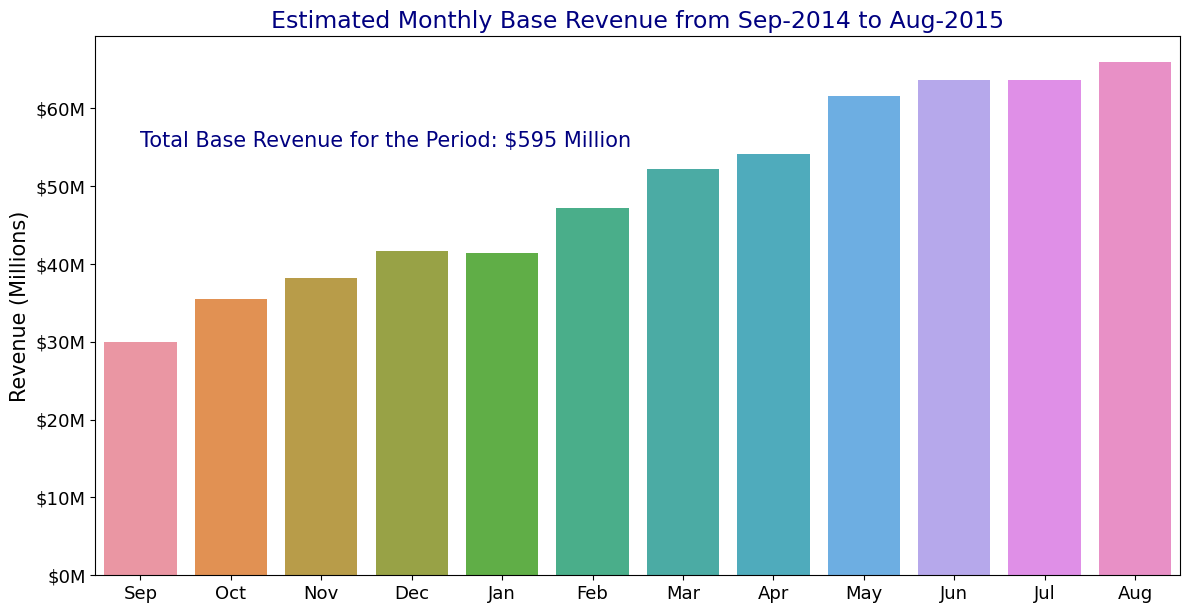

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Define your millions_currency function
def millions_currency(x, pos):
    return "${:,.0f}M".format(x * 1e-6)

# Example data or your data loading logic


months_seq = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']  # Calculate total revenue

plt.figure(figsize=(14, 7))
formatter = FuncFormatter(millions_currency)

ax = sns.barplot(x=byDateRev.index, y= byDateRev.values, order = months_seq)
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

font = {'color': 'navy', 'size': 15}
plt.text(0, 55000000, 'Total Base Revenue for the Period: ${:,.0f} Million'.format(sumRev * 1e-6),
         fontdict=font)
plt.xlabel('')
plt.ylabel('Revenue (Millions)', fontsize=15)
plt.tick_params(labelsize=13)
plt.title('Estimated Monthly Base Revenue from Sep-2014 to Aug-2015', fontsize=17, color='navy')

plt.show()


* It's crucial to remember that Uber will receive roughly 25% of the gross expected income. Thus, it is reasonable to assume that Uber's gross margin in New York City between September 2014 and August 2015 was approximately **150 million dollars**. Taking into account the previously mentioned average fare of 27, the expected gross margin came to around **210 million dollars**.
* Uber's **yearly total revenue** is **595 millio, with a gross margin of 149 millio**n.
* In the bar plot, we can see that, with the exception of the months of January and June, income increased month over month during that time. This may have been caused by the two federal holidays that occurred in January and the beginning of the summer vacation in July.   

In [85]:
df_copy.est_revenue.mean()

19.241863987639547

* Mean fare from revenue estimate for the period: $19.24 (assumes all trips are Uber X)

# Month over Month Base Revenue Growth: how fast has Uber grown in the period?

In [87]:
#Create dictionary with calculated month over month revenue percentage growth:
dict_growth = {}
for i in range(len(months_seq)):
    mo = months_seq[i]
    rev = byDateRev[mo]
    if mo == 9:
        growth_pct = 0
    elif mo == 1:
        growth_pct = ((rev/byDateRev[12]) - 1) * 100
    else:
        growth_pct = ((rev/byDateRev[mo - 1]) - 1) * 100
    print(month_labels[i], 'Revenue =', '${:,.0f}'.format(rev), 'Growth % = ', '{:.1f}%'.format(growth_pct))
    dict_growth[month_labels[i]] = growth_pct

Sep Revenue = $29,967,741 Growth % =  0.0%
Oct Revenue = $35,531,001 Growth % =  18.6%
Nov Revenue = $38,170,687 Growth % =  7.4%
Dec Revenue = $41,661,569 Growth % =  9.1%
Jan Revenue = $41,457,151 Growth % =  -0.5%
Feb Revenue = $47,252,852 Growth % =  14.0%
Mar Revenue = $52,154,385 Growth % =  10.4%
Apr Revenue = $54,095,066 Growth % =  3.7%
May Revenue = $61,539,912 Growth % =  13.8%
Jun Revenue = $63,667,666 Growth % =  3.5%
Jul Revenue = $63,607,348 Growth % =  -0.1%
Aug Revenue = $65,961,099 Growth % =  3.7%


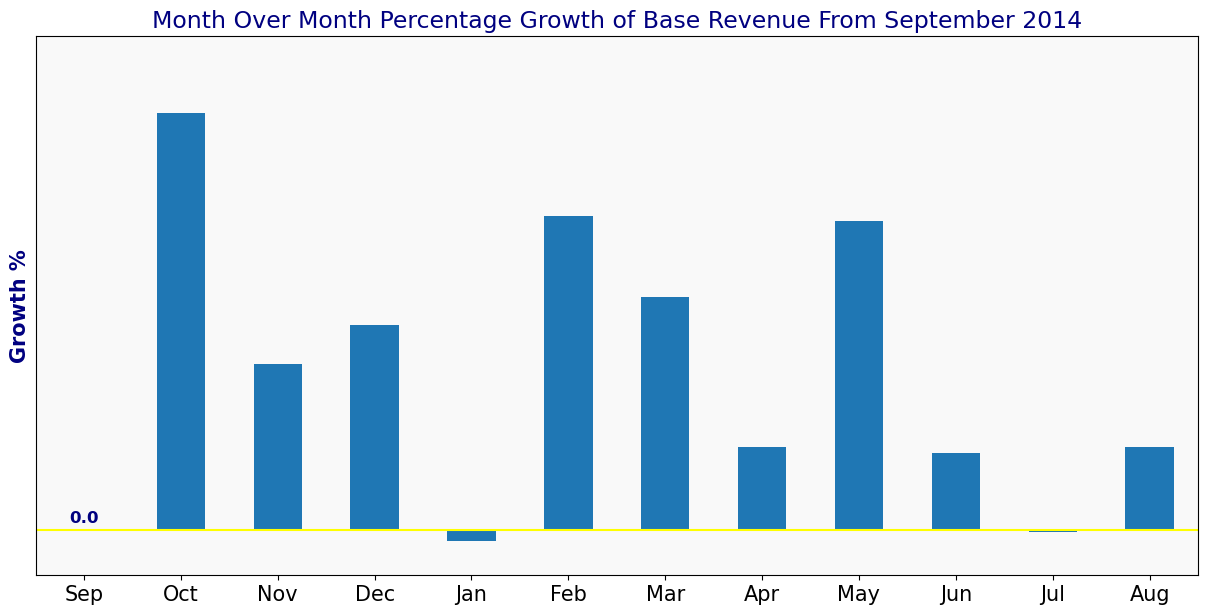

In [88]:
#Annotate Total Cummulative Growth for the Period

df_plt1 = pd.DataFrame(pd.Series(dict_growth), index = month_labels, columns = ['growth_pct'])

labels_list = df_plt1.growth_pct.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt1.plot(kind = 'bar', figsize = (15,7), fontsize = 14, rot = 0, legend=False)#df_plt2[1:] to exclude Sep
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.axhline(0, color='yellow')
plt.title('Month Over Month Percentage Growth of Base Revenue From September 2014', 
          fontsize = 17, color='navy')
plt.ylabel('Growth %', fontsize = 15, weight='bold', color='navy')
plt.ylim(-2, 22)
plt.tick_params(labelsize=15)

plt.show()

Cummulative % Growth Over Period: 83.54793827524881


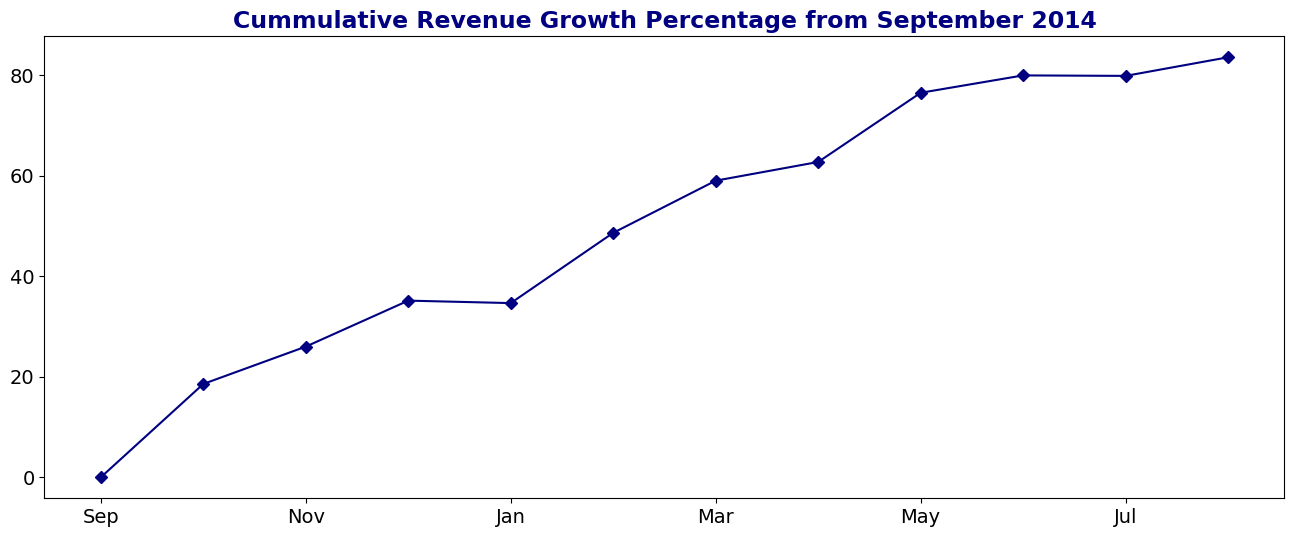

In [89]:
#Plot Cummulative Base Revenue Growth Over the Period
print('Cummulative % Growth Over Period:', df_plt1.growth_pct.sum())

df_plt1.cumsum().plot(color = 'navy', marker = 'D', legend = False, figsize=(16, 6))
plt.title('Cummulative Revenue Growth Percentage from September 2014', fontsize=17, weight='bold', color='navy')
plt.tick_params(labelsize=14)
plt.show()

# Which day of the week has the worst (slowest) traffic overall?

In [93]:
#Create dataframe with grouped data.
df_plt2 = df_copy.groupby('weekday')['trip_avg_speed'].median() #used median since distribution is skewed.

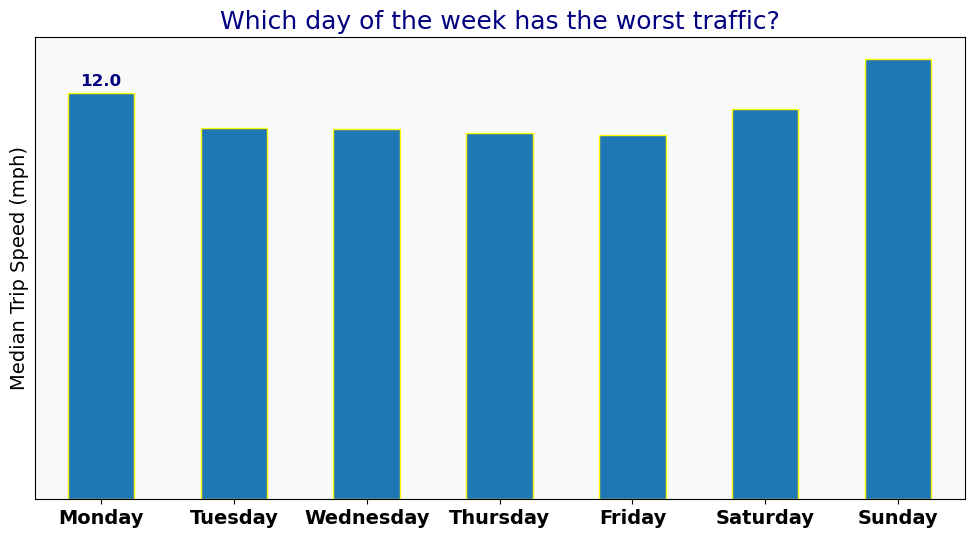

In [94]:
#Create plot. Does Saturday have better traffic flow than Monday?

fig = plt.figure()
labels_list = df_plt2.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt2.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
ax.set_xticklabels(weekday_labels, weight='bold')
ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Median Trip Speed (mph)', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the worst traffic?', fontsize = 18, color='navy')
plt.show()
#plot_url = py.plot_mpl(fig)

* Monday seems to have slightly better flow than the other weekdays, and particularly better than Saturday. As expected, Sunday has the lightest traffic.

# What is the median distance traveled per trip? Are there any insights we can learn from it?

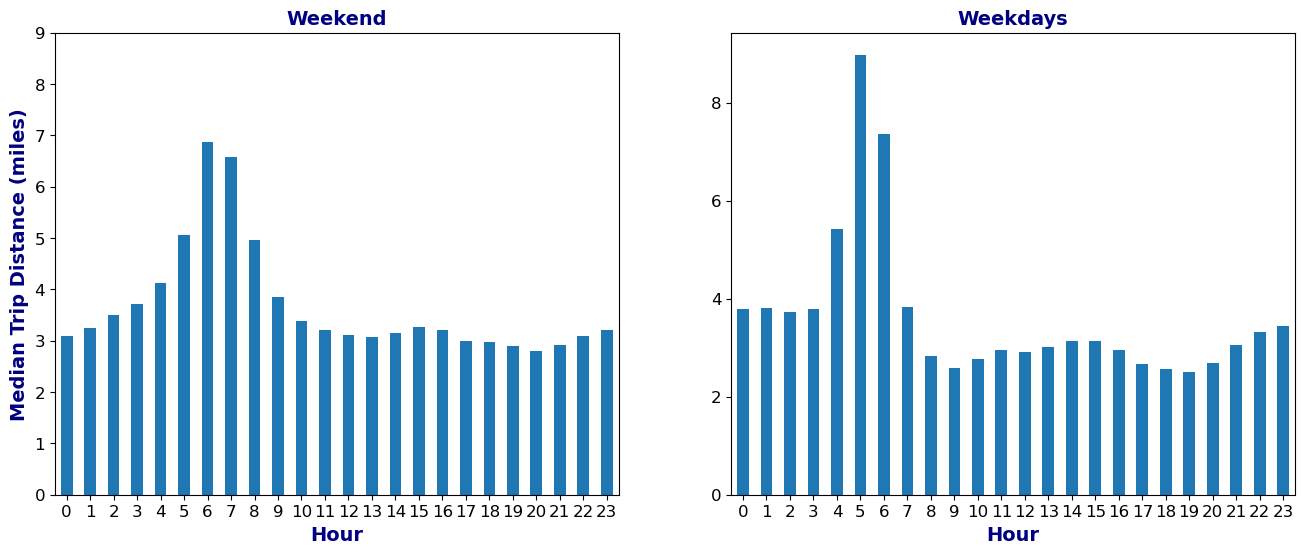

In [96]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
df_copy[(df_copy.weekday >= 5)].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0, fontsize=14)
plt.ylim(0, 9)
plt.tick_params(labelsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=14, weight='bold', color='navy')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend', fontsize=14, weight='bold', color='navy')

plt.subplot(1,2,2)
df_copy[df_copy.weekday < 5].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0)
plt.tick_params(labelsize=12)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekdays', fontsize=14, weight='bold', color='navy')

plt.show()

* Why is there a significant difference in the median distance traveled at 5 AM compared to other times?Is it picking up passengers going to the outer boroughs who would otherwise take public transportation? 
* Although bus services are not available 24/7 in NYC, the subway is. However, it's evident that the majority of customers are from Manhattan.

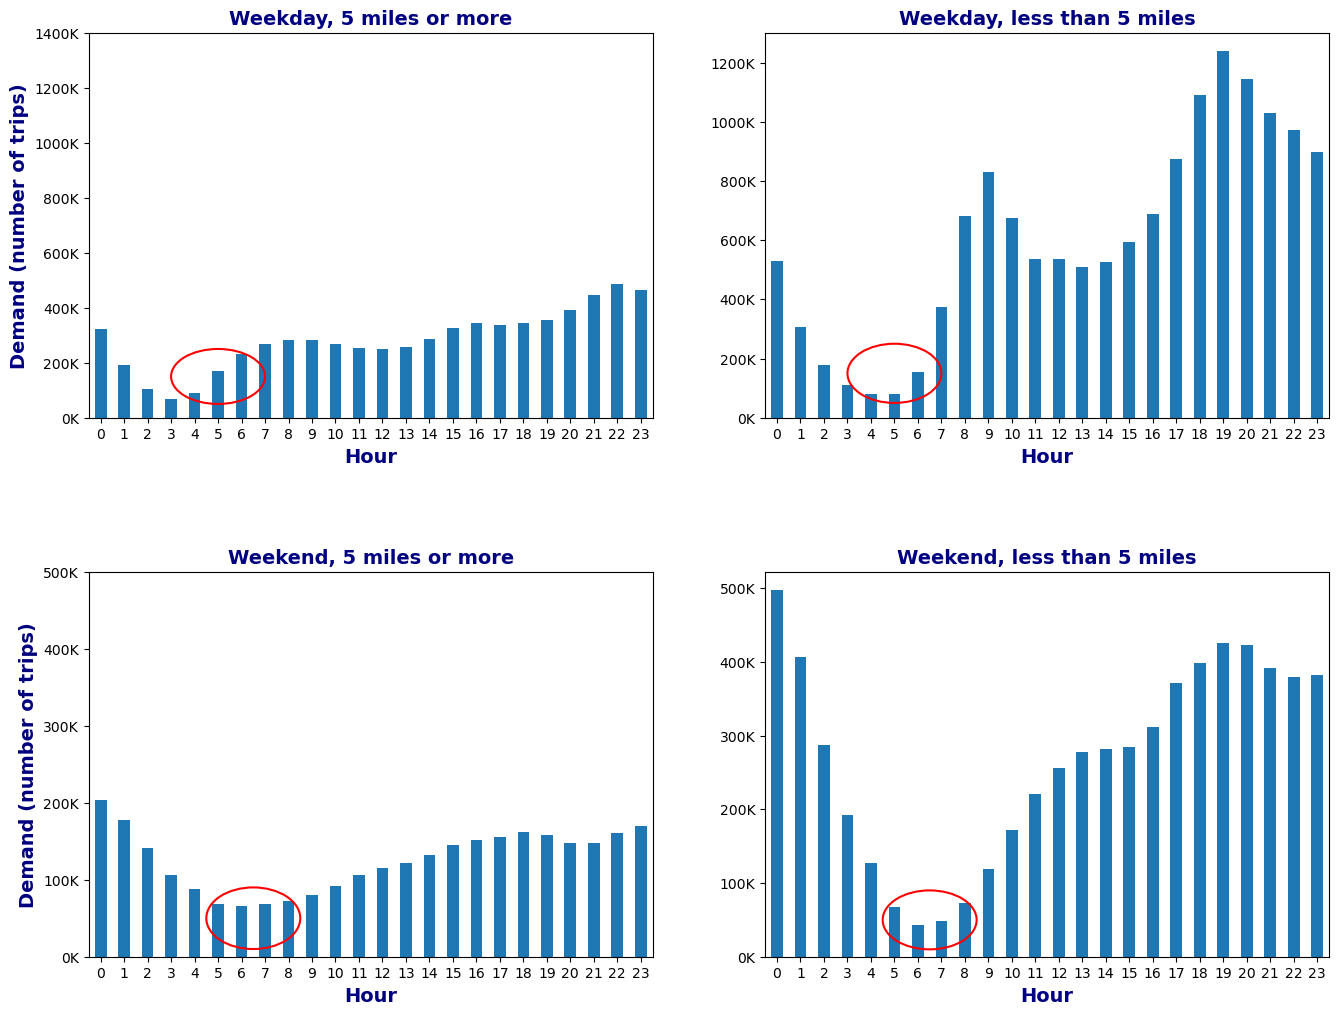

In [102]:
#Create plot similar to the above but with the count of trips per hour, comparing weekday vs weekend and 
#distances >=5 versus < 5 miles. Indeed, the plots show that there is a higher demand for trips that go beyond 
#miles (outside Manhattan) from 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends (Saturday and Sunday).


fig = plt.figure(figsize=(16, 12))
formatter = FuncFormatter(thousands_format)

# Weekday, 5 miles or more
plt.subplot(2, 2, 1)
ax1 = df_copy[(df_copy.weekday < 5) & (df_copy.trip_distance >= 5)].\
    groupby('hour')['trip_distance'].count().plot(kind='bar', rot=0)
ax1.yaxis.set_major_formatter(formatter)
ellipse1 = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax1.add_patch(ellipse1)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 1400000)
plt.title('Weekday, 5 miles or more', fontsize=14, weight='bold', color='navy')

# Weekday, less than 5 miles
plt.subplot(2, 2, 2)
ax2 = df_copy[(df_copy.weekday < 5) & (df_copy.trip_distance < 5)].\
    groupby('hour')['trip_distance'].count().plot(kind='bar', rot=0)
ax2.yaxis.set_major_formatter(formatter)
ellipse2 = Ellipse(xy=(5, 150000), width=4, height=200000, edgecolor='red', fc='None', lw=1.5)
ax2.add_patch(ellipse2)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekday, less than 5 miles', fontsize=14, weight='bold', color='navy')

# Weekend, 5 miles or more
plt.subplot(2, 2, 3)
ax3 = df_copy[(df_copy.weekday >= 5) & (df_copy.trip_distance >= 5)].\
    groupby('hour')['trip_distance'].count().plot(kind='bar', rot=0)
ax3.yaxis.set_major_formatter(formatter)
ellipse3 = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax3.add_patch(ellipse3)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.ylabel('Demand (number of trips)', fontsize=14, weight='bold', color='navy')
plt.ylim(0, 500000)
plt.title('Weekend, 5 miles or more', fontsize=14, weight='bold', color='navy')

# Weekend, less than 5 miles
plt.subplot(2, 2, 4)
ax4 = df_copy[(df_copy.weekday >= 5) & (df_copy.trip_distance < 5)].\
    groupby('hour')['trip_distance'].count().plot(kind='bar', rot=0)
ax4.yaxis.set_major_formatter(formatter)
ellipse4 = Ellipse(xy=(6.5, 50000), width=4, height=80000, edgecolor='red', fc='None', lw=1.5)
ax4.add_patch(ellipse4)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend, less than 5 miles', fontsize=14, weight='bold', color='navy')

fig.subplots_adjust(hspace=0.4)
plt.show()

* The red circles highlight the focus areas where the number of long trips is greater than the number of short trips, and this occurs both on weekdays and weekends, although at slightly different times: the demand is **higher for longer trips from about 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends**.

The demand is **higher for longer trips from about 5 to 7 AM on weekdays, and from 6 to 8 AM on weekends**. The red circles highlight the focus areas where the number of long trips is greater than the number of short trips, and this occurs both on weekdays and weekends, although at slightly different times.

# What are the most popular pickup and drop-off taxi zones?

C:\Users\JAYA PRAKASH\AppData\Local\Temp\ipykernel_23012\721752598.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
C:\Users\JAYA PRAKASH\AppData\Local\Temp\ipykernel_23012\721752598.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])


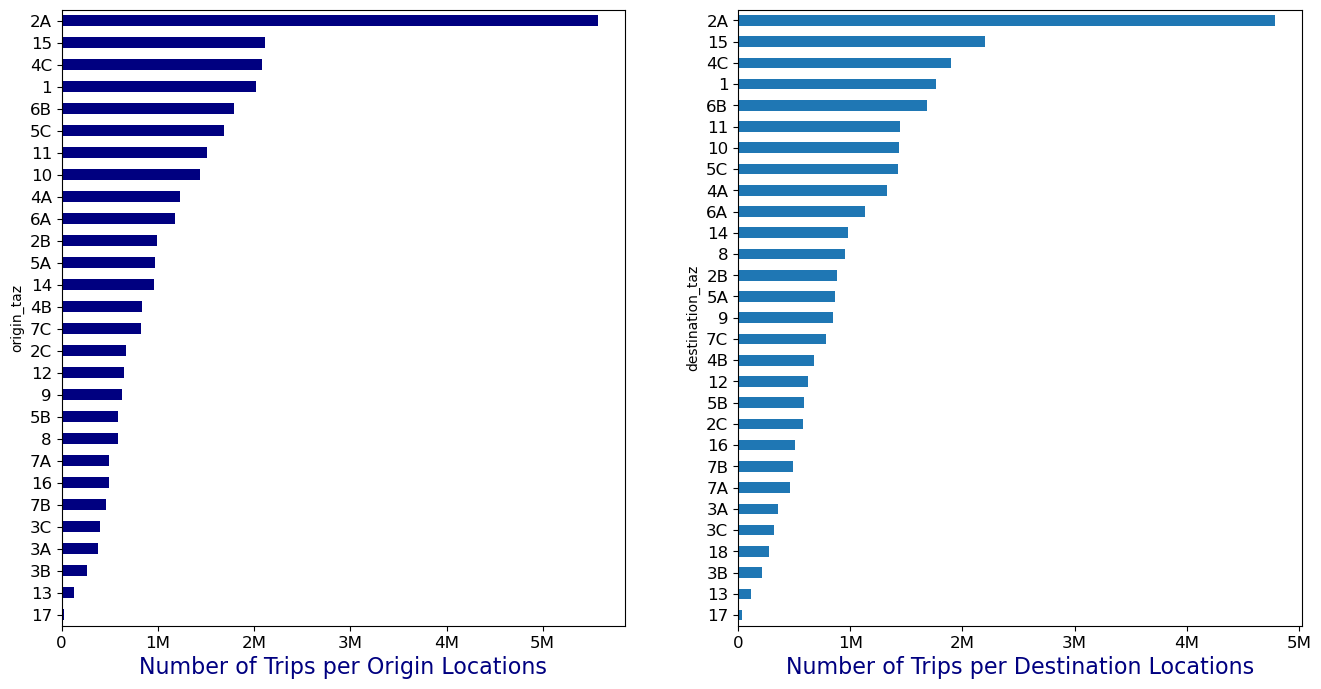

In [105]:
#CREATE INSTEAD SIDE-STACKED PLOT WITH TOP 10 PICKUP AND DROP-OFF LOCATIONS? OR TRY TOYPLOT WITH VALUE FOR EACH BAR.
fig = plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
ax1 = df_copy.origin_taz.value_counts(ascending = True).plot(kind = 'barh', color = 'navy')
ax1.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)
plt.xlabel('Number of Trips per Origin Locations', fontsize = 16, color='navy')

plt.subplot(1,2,2) #note: it won't account missing values (4% of data)
ax2 = df_copy.destination_taz.value_counts(ascending = True).plot(kind = 'barh')
ax2.set_xticklabels(['0', '1M', '2M', '3M', '4M', '5M', '6M'])
plt.tick_params(labelsize=12)
plt.xlabel('Number of Trips per Destination Locations', fontsize = 16, color='navy')

plt.show()
#plot_url = py.plot_mpl(fig)

* The top 5 locations for origin and destination are the same: 2A, 15, 4C, 1, and 6B (likely all in Manhattan).
* The top location for pick up and drop off, 2A, accounts for more than the total trips for the next two popular locations.
*  Top origin codes are **probably based in Manhattan**. In this case, the top **destination codes are also based in Manhattan**.

In [108]:
#Percentage of trips represented by the top five origins/destinations:
print(df_copy.origin_taz.value_counts().head(5).sum()/float(len(df_copy))) #13,583,249
print(df_copy.destination_taz.value_counts().head(5).sum()/float(len(df_copy[df_copy.destination_taz.isnull() == False])))                                                         

0.4392216937318789
0.41585189564289543


In [109]:
#Total pickups or drop-offs within any combination of the top 5 locations: 6231353 (20% of the total trips)
len(df_copy[(df_copy.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_copy.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])

6231752

In [110]:
#29% of all trips start or finish at 2A:
len(df_copy[(df_copy.origin_taz == '2A') | (df_copy.destination_taz == '2A')])/(1.0*len(df_copy)) #8979830

0.29038433027120075

* The most **popular pickup and drop-off locations are 2A**. In fact, **29%** of all Uber trips during the analyzed period have either started or ended in this zone.

# Visualizing the most popular pick up and drop off location pairs.

In [111]:
#Define data to plot:
df_plt3 = df_copy.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

In [113]:
df_plt3.shape

(28, 29)

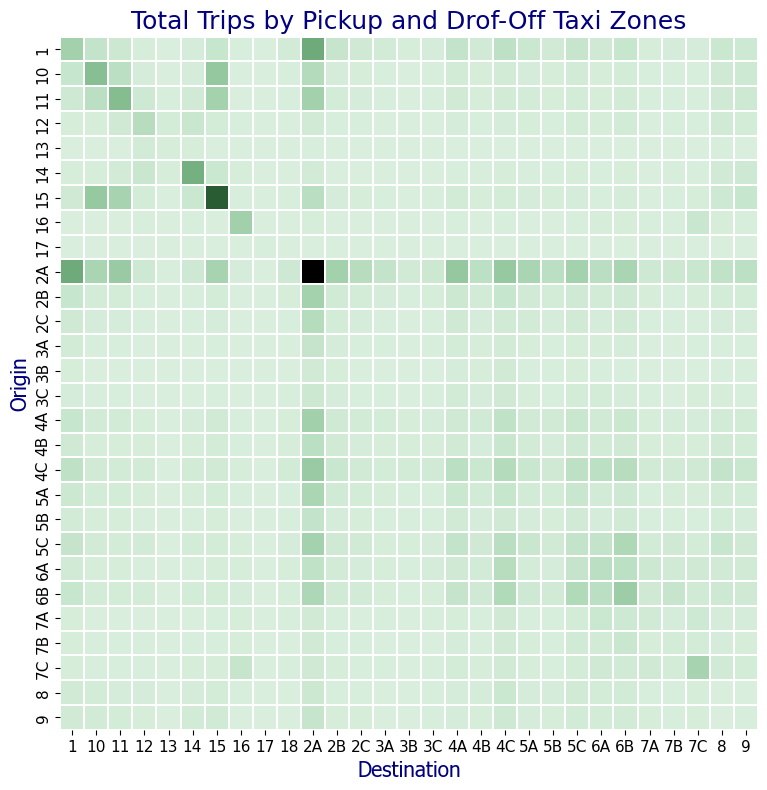

In [114]:
#Visualize the origin versus destination matrix via a heatmap:

fig = plt.figure(figsize=(9,9))

cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.9, as_cmap=True) #'YlOrRd' #ggplot:'viridis'

sns.heatmap(df_plt3, cmap=cmap, linewidths=0.1, cbar=False)

plt.title('Total Trips by Pickup and Drof-Off Taxi Zones', fontsize=18, color='navy')
plt.xlabel('Destination', fontsize=15, fontname='Tahoma', color='navy')
plt.ylabel('Origin', fontsize=15, fontname='Tahoma', color='navy')
plt.tick_params(labelsize=11)
plt.show()

In [118]:
len(df_copy[(df_copy.origin_taz.isin(['2A', '15', '4C', '1', '6B']) == True) & \
           (df_copy.destination_taz.isin(['2A', '15', '4C', '1', '6B']) == True)])

6231752

2A and 2A code have the highest correlation and 15 and 15 after that is one of most pickup and drop locations.

In [120]:
#Plot the mean travel time from the most popular origin, to all possible destinations.
df_plt4 = df_copy[df_copy.origin_taz == '2A'].groupby('destination_taz')['trip_distance'].mean().sort_values()
df_plt5 = df_copy[df_copy.origin_taz == '2A'].groupby('destination_taz')['duration_in_min'].mean().sort_values()

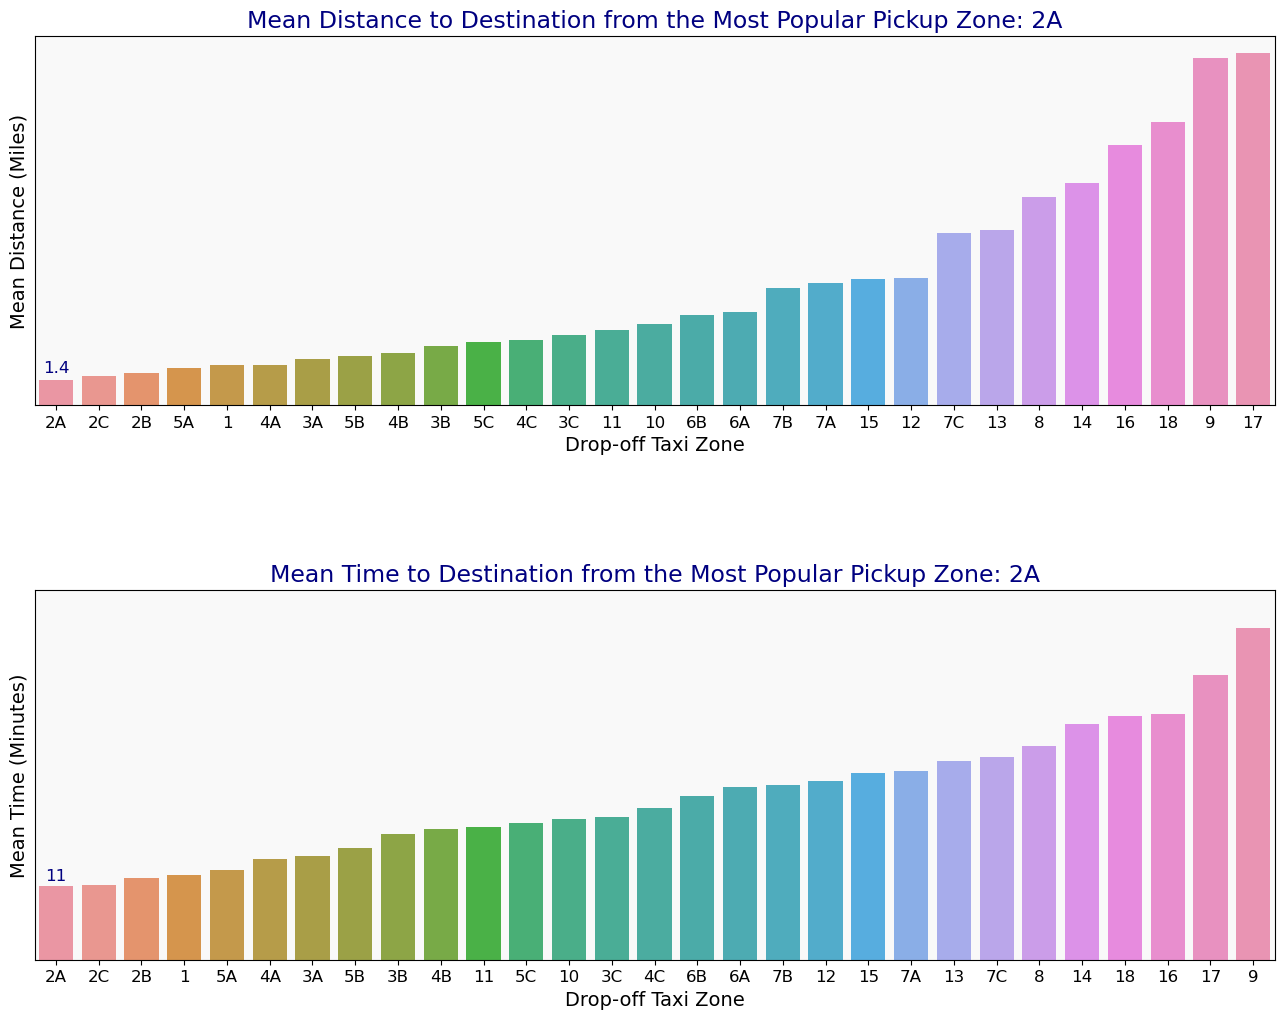

In [121]:
#Assuming 18 is EWR, and given the average driving distance from 2A, this pick up location is probably located in 
#Midtown, not in Lower Manhattan (Penn Station lat/long: 40.750568, -73.993519)
#Straight line distance: 11 miles, Driving distance: 15 miles Difference: 36%
#The mean time and distance to zone 18 adds further evidence that it's the EWR airport (from Midtown).
#Based on the distance from 2A, if the origin is Midtown, then 15 is in Upper Manhattan.

fig = plt.figure(figsize = (16,12))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'color': 'navy'}


plt.subplot(2,1,1)
ax1 = sns.barplot(x=df_plt4.index, y=df_plt4.values)
ax1.set_facecolor('#F9F9F9')
#ax1.set_yticks(range(0, 21, 2))
ax1.get_yaxis().set_ticks([])
labels_list = df_plt4.values.round(1)
annotate_labels(ax1, labels_list, **kwargs)
plt.title('Mean Distance to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Distance (Miles)', fontsize = 14)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


plt.subplot(2,1,2)
ax2 = sns.barplot(x=df_plt5.index, y=df_plt5.values)
ax2.set_facecolor('#F9F9F9')
#ax2.set_yticks(range(0, 51, 5))
ax2.get_yaxis().set_ticks([])
labels_list = df_plt5.apply(lambda x: '{:.0f}'.format(round(x))).values
annotate_labels(ax2, labels_list, **kwargs)
plt.title('Mean Time to Destination from the Most Popular Pickup Zone: 2A', fontsize=17, color='navy')
plt.ylabel('Mean Time (Minutes)', fontsize = 14)
plt.ylim(0,55)
plt.xlabel('Drop-off Taxi Zone', fontsize=14)
plt.tick_params(labelsize=12)


fig.subplots_adjust(hspace=.5)
plt.show()
#plot_url = py.plot_mpl(fig)

* The charts above show the mean distance and time to destination for a trip originating at 2A.
* The data has 28 unique origin codes and 29 unique destination codes. Assuming that code 18, the extra destination code, represents the Newark Airport (EWR), a relevant destination outside of New York City, then we can infer that 2A is in Midtown, based on the mean time and distance to arrive at location 18.

* Given the concentrated demand within Manhattan, about 68% of all Uber trips have a driven distance of 5 miles or less.

# Visualization of Variable Distributions and Bivariate Relationships.

## Distribution of trip distance

In [124]:
df_copy.trip_distance.max(), df.trip_distance.max()

(568.57, 2593.08)

In [126]:
freq, bins_dist = np.histogram(df_copy.trip_distance, bins=10, range=(0, 25))
freq, bins_dist

(array([12709827,  8364570,  3567013,  2035400,  1296935,   672724,
          706029,   747773,   299952,   132574], dtype=int64),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]))

In [127]:
#69% of all trips had distance < 5 miles
for val in freq:
    print(float(val)/sum(freq))

0.4162680215638286
0.27395361125939427
0.11682562196971343
0.06666274301695976
0.042476783243932746
0.022032832432613364
0.02312362670213279
0.024490812289486612
0.009823928020744381
0.004342019501194077


In [128]:
df_copy.trip_distance.median(), df_copy.trip_distance.mean()

(3.09, 5.199671270671474)

In [129]:
print(len(df_copy[df_copy.trip_distance <= 5]) / (1.0 * len(df_copy))) # 68% of trips are 5 miles or less
print(len(df_copy[df_copy.trip_distance <= 2]) / (1.0 * len(df_copy))) # 32% of trips are 2 miles or less

0.6821346964320677
0.3192324550376767


In [130]:
#Vey long distance trips (>= 300 miles):
df_copy[df_copy.trip_distance >= 300].head(10) #45 total

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed,est_revenue
943214,19594602,10,15,2014-09-16 10:00:00,371.55,2014-09-16,2014,9,16,10,1,474.283333,47.003549,818.761667
3620586,5138875,14,NaN,2014-11-04 23:00:00,357.27,2014-11-04,2014,11,4,23,1,309.516667,69.257014,736.103333
10581718,10072444,16,NaN,2015-02-04 18:00:00,330.90,2015-02-04,2015,2,4,18,2,648.500000,30.615266,808.600000
11224977,17353914,15,15,2015-02-25 15:00:00,378.01,2015-02-25,2015,2,25,15,2,600.766667,37.752760,874.335833
11684172,23119455,14,14,2015-02-03 18:00:00,350.15,2015-02-03,2015,2,3,18,1,559.350000,37.559667,811.085000
13829799,16426984,15,NaN,2015-03-27 19:00:00,568.57,2015-03-27,2015,3,27,19,4,652.316667,52.296993,1225.858333
16530542,15478567,7A,17,2015-04-09 01:00:00,315.57,2015-04-09,2015,4,9,1,3,248.066667,76.327063,641.620833
18643154,6860856,5C,16,2015-05-31 05:00:00,308.42,2015-05-31,2015,5,31,5,6,304.183333,60.835680,648.749167
18854980,9245564,15,15,2015-05-10 22:00:00,302.79,2015-05-10,2015,5,10,22,6,441.666667,41.133736,687.015833
18949729,10208984,4A,7C,2015-05-09 16:00:00,335.30,2015-05-09,2015,5,9,16,5,813.666667,24.725113,874.108333


## Distribution of trip duration (in minutes)

In [133]:
#Median trip duration is ~ 17 minutes
df_copy['duration_in_min'].describe()

count    3.092562e+07
mean     2.099209e+01
std      1.608435e+01
min      0.000000e+00
25%      1.085000e+01
50%      1.723333e+01
75%      2.668333e+01
max      9.593000e+02
Name: duration_in_min, dtype: float64

In [134]:
freq, bins_dur = np.histogram(df_copy['duration_in_min'], bins=10, range=(0, 50))
freq, bins_dur

(array([1235201, 5391527, 6312324, 5266965, 3929223, 2777187, 1878407,
        1256167,  852543,  589921], dtype=int64),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

## Plot of the histograms for trip distance and duration

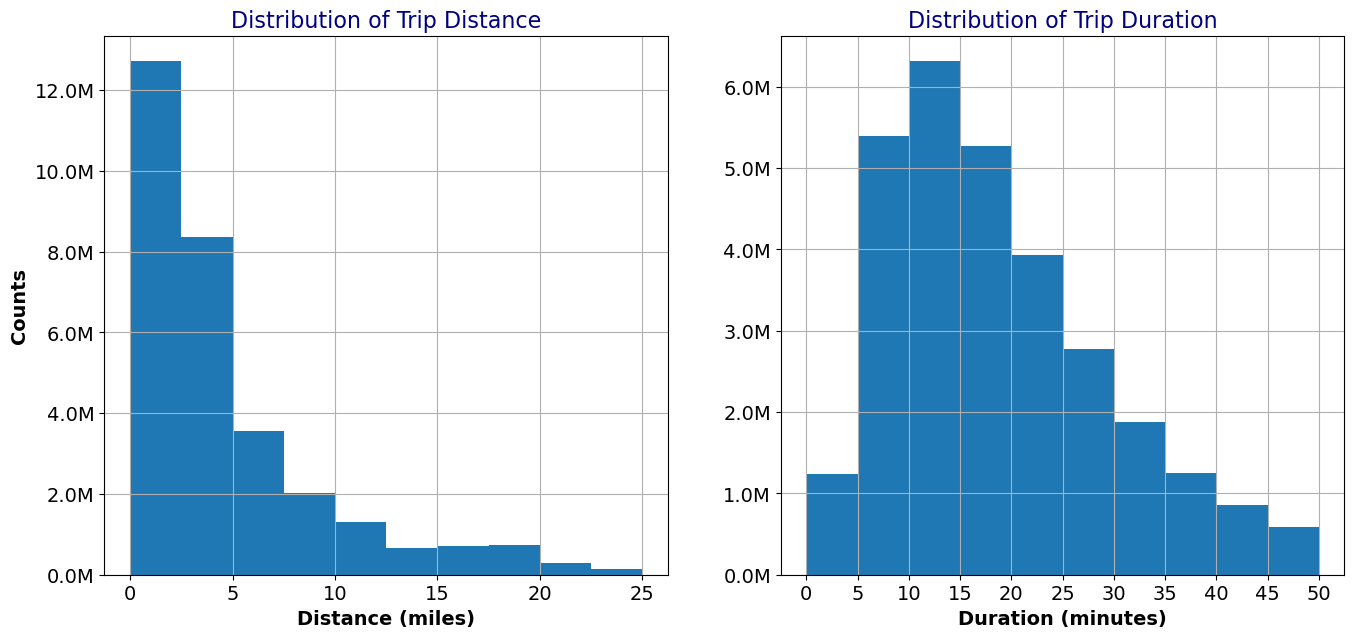

In [136]:
#Here we plot the distribution of trip duration next to the histogram of trip distance for comparison.
fig = plt.figure(figsize=(16, 7))

formatter = FuncFormatter(millions_format)

plt.subplot(1,2,1)
ax1 = df_copy.trip_distance.dropna().hist(bins=bins_dist)
ax1.yaxis.set_major_formatter(formatter)

plt.xlabel('Distance (miles)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Distance', color='navy', fontsize=16)


plt.subplot(1,2,2)
ax2 = df_copy.duration_in_min.hist(bins=bins_dur)
ax2.yaxis.set_major_formatter(formatter)
ax2.set_xticks(bins_dur) #bins are in 5 minutes intervals.

plt.xlabel('Duration (minutes)', fontsize=14, weight='bold')
plt.ylabel('')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Duration', color='navy', fontsize=16)

plt.show()

* The histograms above illustrate the distribution of the distance and duration of Uber trips.



## Distribution of the average speed per trip

In [142]:
#Note: this uses processed data (24904 (0.08%) entries with null or zero in duration resulted in null value for speed)
df_copy['trip_avg_speed'].describe()

count    3.090075e+07
mean     1.350735e+01
std      1.175680e+01
min      0.000000e+00
25%      8.410012e+00
50%      1.144891e+01
75%      1.626687e+01
max      2.254800e+04
Name: trip_avg_speed, dtype: float64

In [144]:
freq, bins = np.histogram(df_copy['trip_avg_speed'], bins=10, range=(0, 50))
freq, bins

(array([ 1313452, 10564985,  9862416,  4248624,  2152852,  1282011,
          767843,   434359,   196184,    61865], dtype=int64),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

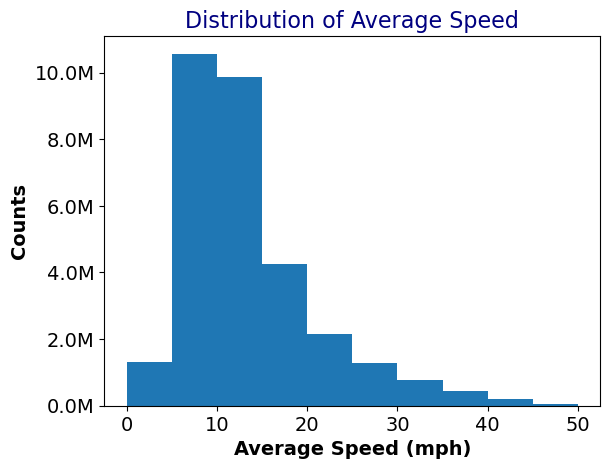

In [146]:
fig, ax = plt.subplots(1,1)

formatter = FuncFormatter(millions_format)

ax.hist(df_copy.trip_avg_speed.dropna(), bins)
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Average Speed (mph)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Average Speed', color='navy', fontsize=16)
plt.show()

In [147]:
#Median trip average speed during weekdays:
df_plt7 = df_copy[df_copy.weekday < 5].groupby('hour')['trip_avg_speed'].median()
df_plt7.head()

hour
0    14.301370
1    15.374738
2    16.127389
3    16.612460
4    19.501926
Name: trip_avg_speed, dtype: float64

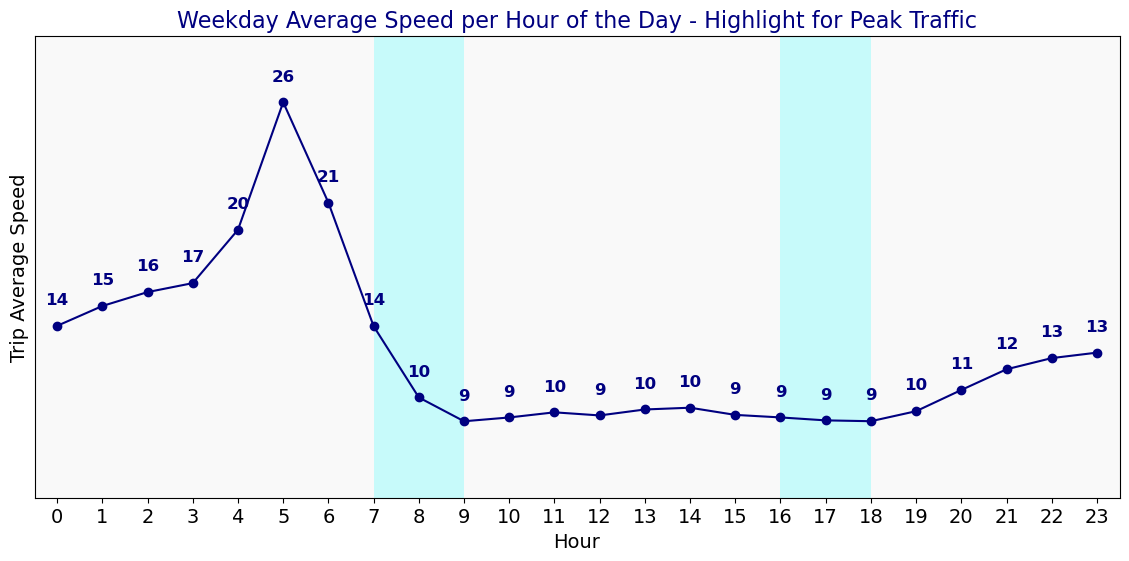

In [148]:
#Plot Peak Hour Median Trip Average Speed During Weekdays:

plt.figure(figsize =(14, 6))
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'top', 'color': 'navy', 'weight': 'bold'}

#weekdays only: rush hour traffic 7-9 + 16-18
ax = df_plt7.plot(marker = 'o', color = 'navy')

for x, y in zip(df_plt7.index, df_plt7.values):
    ax.annotate('{:.0f}'.format(y), xy=(x, y), xytext= (0, 24), textcoords='offset points', **kwargs)

ax.set_facecolor('#F9F9F9')
ax.get_yaxis().set_ticks([]) #hide tick labels on y-axis
plt.fill([7,9,9,7], [0,0,30,30], 'cyan', alpha=0.2)
plt.fill([16,18,18,16], [0,0,30,30], 'cyan', alpha=0.2)
plt.xticks(range(24))
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Trip Average Speed', fontsize=14)
plt.ylim(5, 30)
plt.xlim(-0.5, 23.5)
plt.tick_params(labelsize=14)
plt.title('Weekday Average Speed per Hour of the Day - Highlight for Peak Traffic', fontsize = 16, color='navy')
plt.show()

In [149]:
def is_peak_hour(x):
    """ 
    Function that takes an array(x) with two integers representing 
    hour of the day and weekday, respectively, and
    returns 1 if it's peak hour as defined, 0 otherwise.
    """
    return 1 if x[0] in (7,8,9,16,17,18) and x[1] < 5 else 0 #total peak hour periods = 6h

In [150]:
df_copy['peak_hour'] = pd.Series(map(lambda x: is_peak_hour(x), df_copy.loc[:, ['hour', 'weekday']].values))

In [151]:
df_copy.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,pu_date,year,month,day,hour,weekday,duration_in_min,trip_avg_speed,est_revenue,peak_hour
0,252581,7C,6A,2014-09-01 09:00:00,4.25,2014-09-01,2014,9,1,9,0,15.183333,16.794731,15.301667,1.0
1,252582,7B,15,2014-09-01 18:00:00,10.17,2014-09-01,2014,9,1,18,0,34.083333,17.903178,32.276667,1.0
2,252583,11,2A,2014-09-01 17:00:00,4.02,2014-09-01,2014,9,1,17,0,17.100000,14.105263,15.570000,1.0
3,252584,3B,4A,2014-09-01 13:00:00,1.46,2014-09-01,2014,9,1,13,0,6.533333,13.408163,8.000000,0.0
4,252585,2A,10,2014-09-01 14:00:00,8.31,2014-09-01,2014,9,1,14,0,26.283333,18.970197,26.291667,0.0


AttributeError: 'numpy.float64' object has no attribute 'startswith'

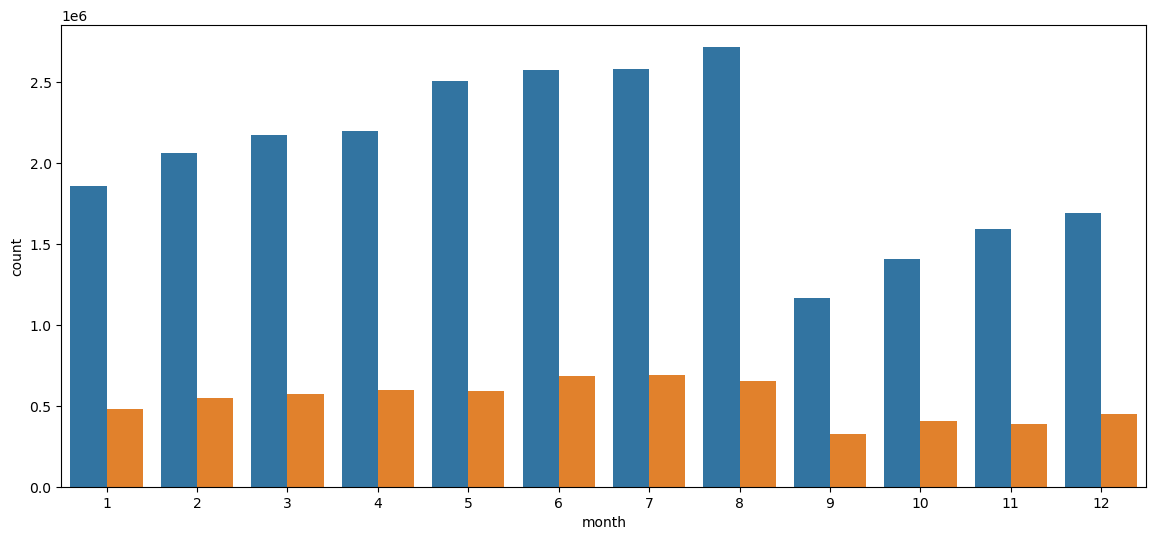

In [152]:
#Plot the total number of trips per month during peak hours and off-peak hours.
#Count for peak hours must represent more than 25% (6h) of the total rides to be more significant than non-peak hours.
plt.figure(figsize = (14, 6))
formatter = FuncFormatter(millions_format)

#to add labels and operate on data, use pivot instead of countplot directly with hue.
ax = sns.countplot(x = df_copy['month'], hue = df_copy['peak_hour'])
ax.set_xticklabels(month_labels)
ax.yaxis.set_major_formatter(formatter)

handles, labels = ax.get_legend_handles_labels() #will cause the warning msg that can be ignored 
plt.legend(handles, labels=['Peak', 'Off Peak'], loc='best', fontsize=13)
plt.tick_params(labelsize=13)
plt.xlabel('Month (2014 - 2015)', fontsize = 15, weight='bold')
plt.ylabel('Total Trips', fontsize = 15, weight='bold')
plt.title('Demand of Rides per Month - Peak versus Off-Peak Hours', fontsize = 17, color='navy')
plt.show()